# Integration and calibration benchmarks

This benchmark requires the `DL1_integrations.h5` file produced by `Preparation/integration_prep.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry

from h5py import File

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"));

In [3]:
input_dir = '../../Preparation'

channel = 0 # gain channel

pe_max = 50

In [4]:
filename = input_dir + '/DL1_integrations.h5'

In [5]:
file = File(filename)

In [6]:
integrators = list(file.keys())
cam_ids = list(file[integrators[0]])

## Introduction

In this benchmark, we select the pixels containing signal based on the true photo-electron images.   
Here is an example:

FlashCam
LSTCam
NectarCam


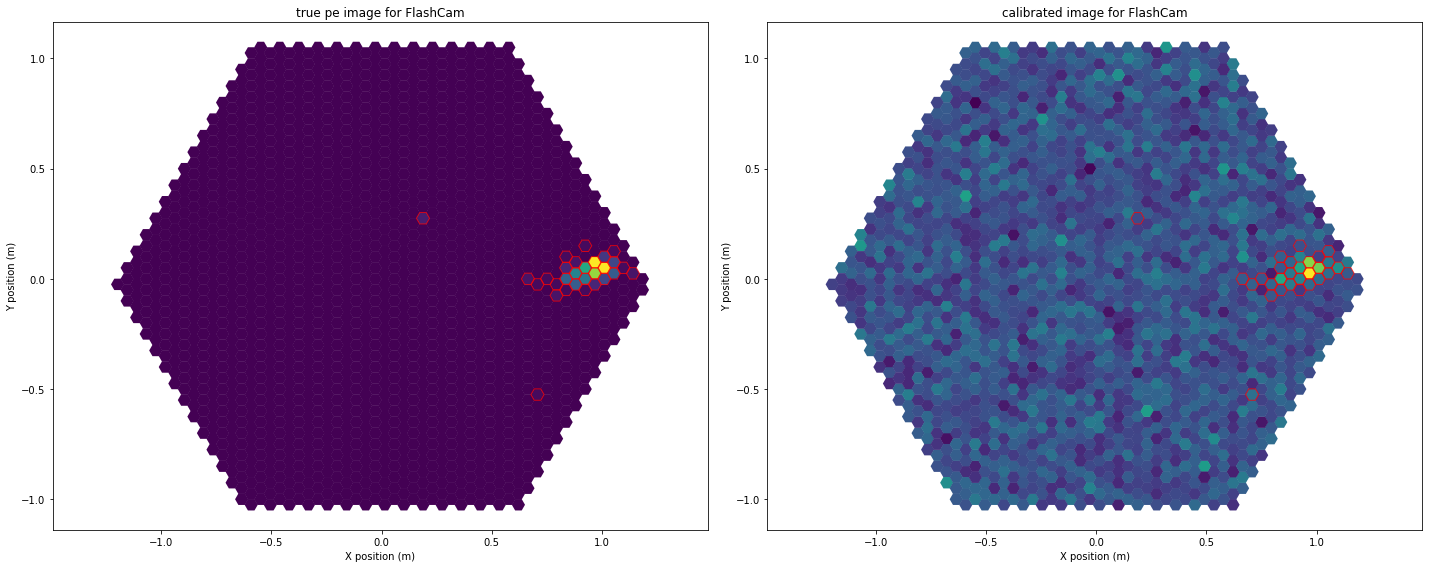

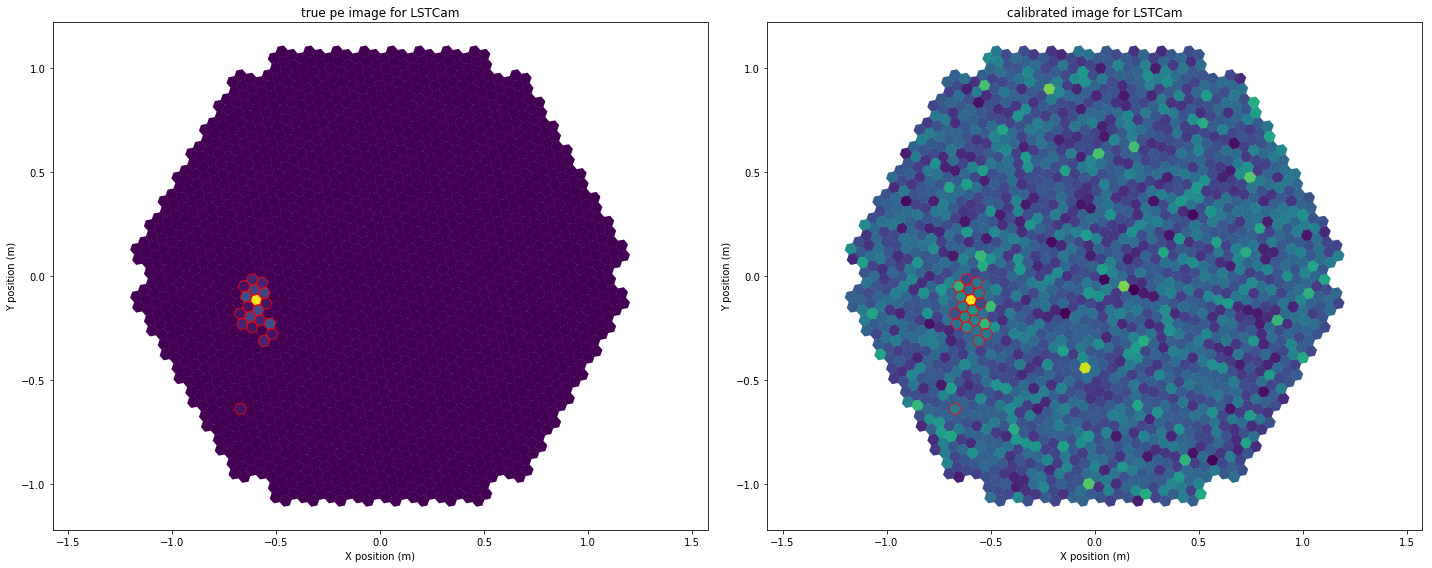

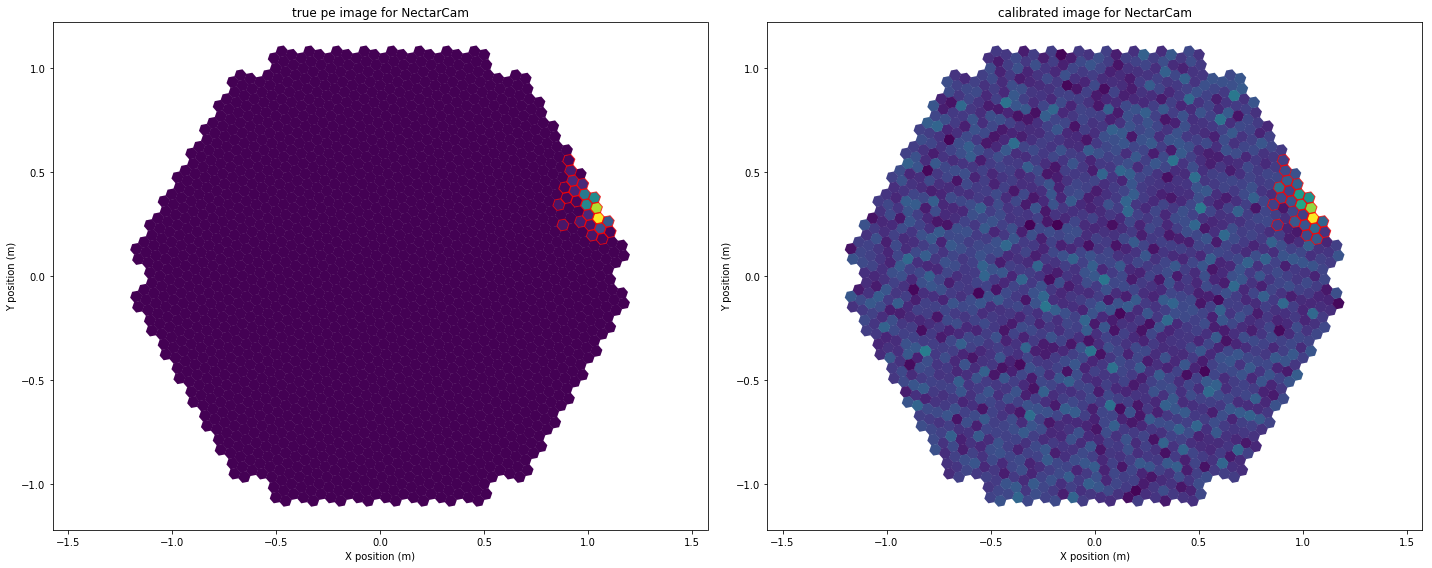

In [7]:
integrator = integrators[0]

for cam_id in cam_ids:
    print(cam_id)
    calibrated_image = file[integrator][cam_id]['image_calibrated'][0][0]
    pe_image = file[integrator][cam_id]['image_true_pe'][0]
    mask = pe_image > 0
    geom = CameraGeometry.from_name(cam_id)
    
    fig, axes = plt.subplots(1,2, figsize=(20,8))
    display = CameraDisplay(geom, pe_image, ax=axes[0])
    display.highlight_pixels(mask, color='red')
    axes[0].set_title('true pe image for {}'.format(cam_id))
    display = CameraDisplay(geom, calibrated_image, ax=axes[1])
    display.highlight_pixels(mask, color='red')
    axes[1].set_title('calibrated image for {}'.format(cam_id))
    
    plt.tight_layout()
    plt.savefig('pixel_selection.png')

## Background distribution

FullIntegrator
--------
FlashCam
pixels with signal
min: -13.83	max: 199.05	mean: 8.18
pixels with no signal
min: -20.11	max: 31.61	mean: 0.05

LSTCam
pixels with signal
min: -7.73	max: 164.77	mean: 13.74
pixels with no signal
min: -10.45	max: 25.46	mean: 0.03

NectarCam
pixels with signal
min: -12.54	max: 129.83	mean: 7.98
pixels with no signal
min: -17.28	max: 33.28	mean: 0.04



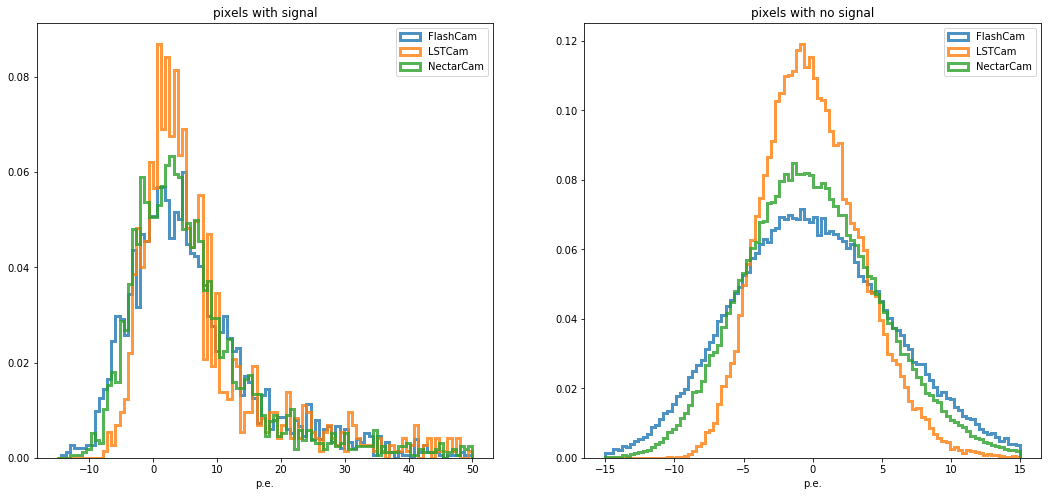

LocalPeakIntegrator
--------
FlashCam
pixels with signal
min: -3.99	max: 180.71	mean: 9.40
pixels with no signal
min: -6.98	max: 27.27	mean: 3.04

LSTCam
pixels with signal
min: -1.64	max: 138.40	mean: 13.45
pixels with no signal
min: -2.98	max: 26.77	mean: 1.86

NectarCam
pixels with signal
min: -0.61	max: 122.99	mean: 8.47
pixels with no signal
min: -1.98	max: 26.41	mean: 2.66



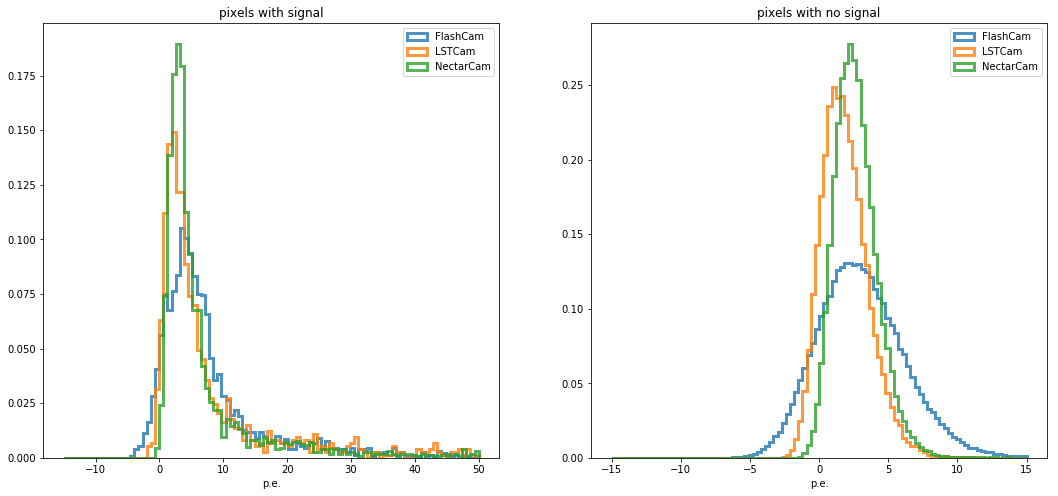

NeighbourPeakIntegrator
--------
FlashCam
pixels with signal
min: -7.93	max: 180.71	mean: 7.53
pixels with no signal
min: -9.92	max: 28.79	mean: 0.01

LSTCam
pixels with signal
min: -2.78	max: 151.75	mean: 12.61
pixels with no signal
min: -3.21	max: 15.58	mean: -0.00

NectarCam
pixels with signal
min: -2.72	max: 122.99	mean: 6.92
pixels with no signal
min: -3.23	max: 22.62	mean: 0.00



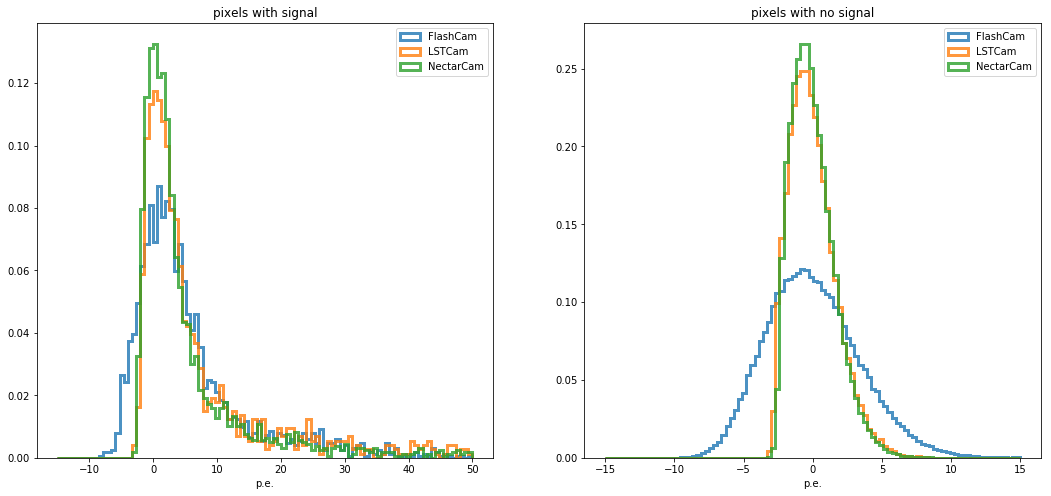

In [8]:
for integrator in integrators:
    print(integrator)
    print('--------')
    
    fig, axes = plt.subplots(1, 2, figsize=(18,8))
    opt = dict(bins=100, alpha=0.8, density=True, histtype='step', lw=3)

    for cam_id in list(file[integrator]):

        cal_image = file[integrator][cam_id]['image_calibrated'][:,channel,:]
        pe_image = file[integrator][cam_id]['image_true_pe']
        mask_background = pe_image > 0
        masked_images = np.ma.array(cal_image, mask=mask_background)

        axes[0].set_title("pixels with signal".format(cam_id))
        pixels_intensity = masked_images.data[masked_images.mask]
        axes[0].hist(pixels_intensity, range=(-15, 50), label=cam_id, **opt);
        axes[0].set_xlabel("p.e.")

        print("{}".format(cam_id))
        print("pixels with signal")
        print("min: {:.2f}\tmax: {:.2f}\tmean: {:.2f}".format(pixels_intensity.min(), 
                                                               pixels_intensity.max(),
                                                               pixels_intensity.mean()))



        axes[1].set_title("pixels with no signal".format(cam_id))
        pixels_intensity = masked_images.data[~masked_images.mask]
        axes[1].hist(pixels_intensity, range=(-15, 15), **opt, label=cam_id);
        axes[1].set_xlabel("p.e.")

        print("pixels with no signal")
        print("min: {:.2f}\tmax: {:.2f}\tmean: {:.2f}\n".format(pixels_intensity.min(), 
                                                               pixels_intensity.max(),
                                                               pixels_intensity.mean()
                                                              ))
    
    axes[0].legend();
    axes[1].legend();
    plt.show()

## Dispersion

FlashCam
------------


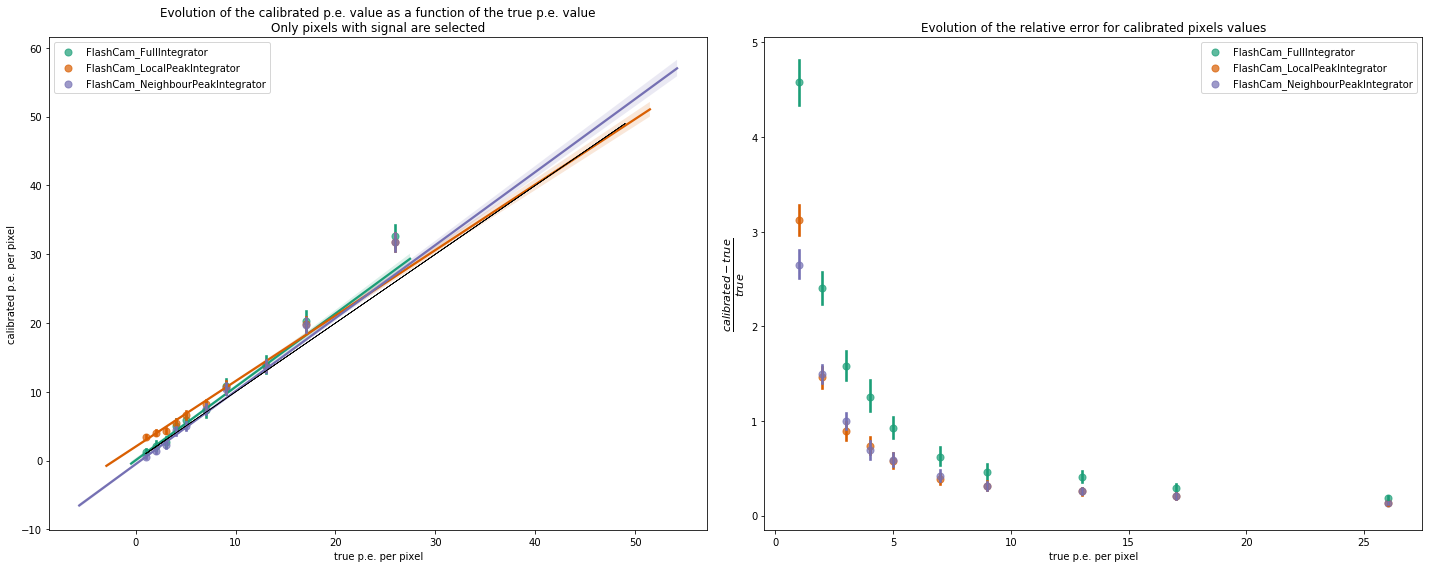

LSTCam
------------


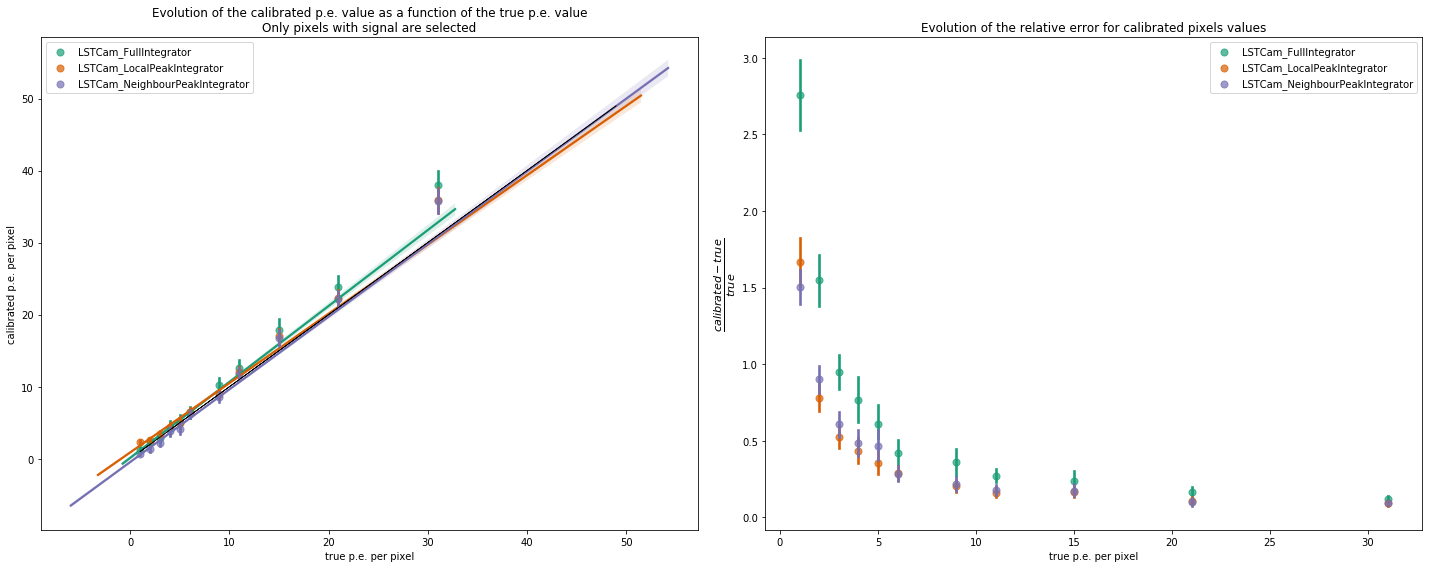

NectarCam
------------


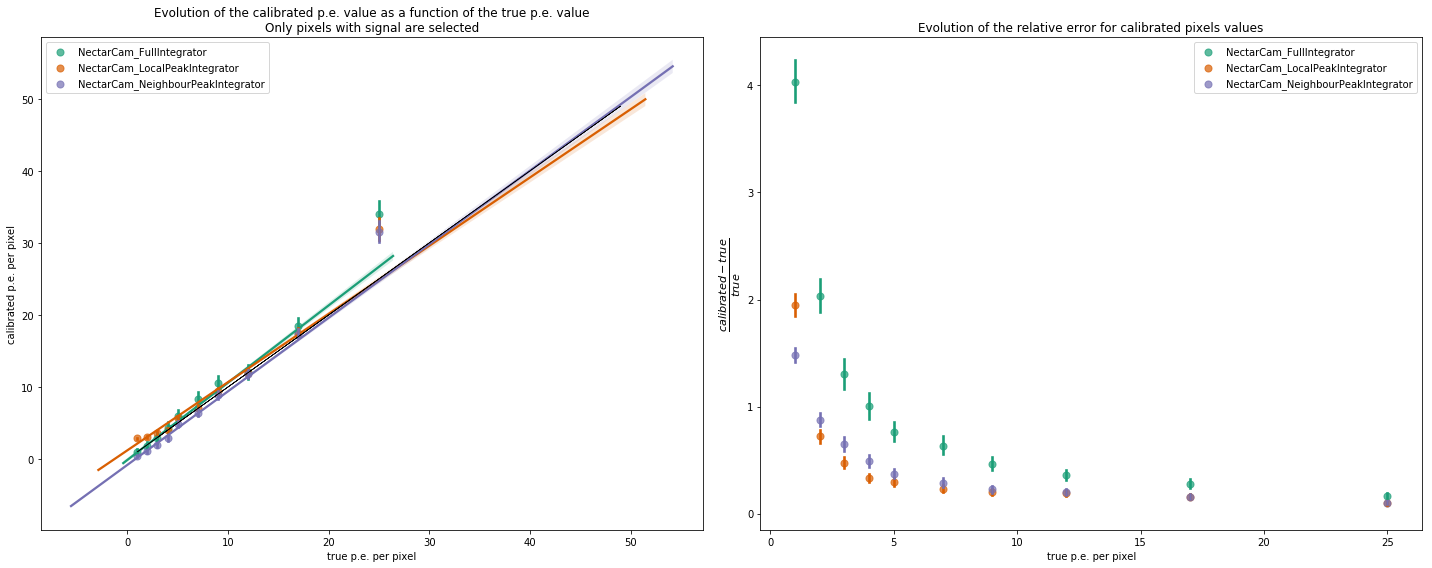

In [9]:

for cam_id in cam_ids:
    print(cam_id)
    print('------------')
    
    fig_px, axes_px = plt.subplots(1, 2, figsize=(20,8))
    
    for ii, integrator in enumerate(integrators):

 
        calibrated_images = file[integrator][cam_id]['image_calibrated'][:,channel,:]
        pe_image = file[integrator][cam_id]['image_true_pe']
        mc_energy = file[integrator][cam_id]['mcevent_energy']
        
        # select only pixels with signal
        signal_pixels = pe_image > 0
        
        x = pe_image[signal_pixels]
        y = calibrated_images[signal_pixels]
        
        y = y[x < pe_max]
        x = x[x < pe_max]

        sns.regplot(x, y,
                    label=cam_id+'_'+integrator,
                    scatter_kws={'alpha':0.7},
                    x_bins = 20,
                    ax=axes_px[0],
                    color=plt.cm.Dark2(ii),
                   )
        axes_px[0].plot(x, x, color='black', lw=0.5)
               
        sns.regplot(x, np.abs(y - x)/x,
                    label=cam_id+'_'+integrator,
                    scatter_kws={'alpha':0.7},
                    x_bins = 20,
                    ax=axes_px[1],
                    color=plt.cm.Dark2(ii),
                    fit_reg=False,
               )


    axes_px[0].legend()
    axes_px[0].set_xlabel('true p.e. per pixel')
    axes_px[0].set_ylabel('calibrated p.e. per pixel')
    axes_px[0].set_title('Evolution of the calibrated p.e. value as a function of the true p.e. value\nOnly pixels with signal are selected')
    axes_px[1].legend()
    axes_px[1].set_xlabel('true p.e. per pixel')
    axes_px[1].set_ylabel(r'$\frac{calibrated - true}{true}$', fontsize=16)
    axes_px[1].set_title('Evolution of the relative error for calibrated pixels values')
    
    plt.tight_layout()
    plt.show()

In [10]:
file.close()